In [5]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [HumanMessage(content="I am researching ocan mammals", name="Lance")]
messages.append(AIMessage(content=f"So you said you were researching ocean mammals?", name="Model"))
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

I am researching ocan mammals
================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [6]:
from langchain.chat_models import init_chat_model
llm = init_chat_model(
    "anthropic.claude-3-haiku-20240307-v1:0",
    model_provider="bedrock_converse",
)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [7]:
result

AIMessage(content="Here are some of the best places in the United States to see killer whales (orcas):\n\n1. San Juan Islands, Washington: The San Juan Islands in the Puget Sound are one of the most famous orca watching destinations in the US. The resident Southern Resident killer whales can be seen here, especially during the spring, summer, and fall.\n\n2. Vancouver Island, British Columbia: While not in the US, the waters around Vancouver Island, just across the border from Washington, are also excellent for orca watching. Many tour companies operate out of Victoria and other coastal towns.\n\n3. Monterey Bay, California: Orcas can sometimes be spotted in the productive waters of Monterey Bay, especially during the migration seasons in spring and fall.\n\n4. Juneau, Alaska: Alaska's Inside Passage near Juneau is home to several different orca populations that can be seen on whale watching tours, especially in the summer months.\n\n5. The Florida Keys: While not as common as on the w

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [10]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'tooluse_cv33NRv2QV6CvLFkLz-BkA',
  'type': 'tool_call'}]

In [14]:
# from typing_extensions import TypedDict
# from langchain_core.messages import AnyMessage
# from typing import Annotated
# from langgraph.graph.message import add_messages
# class MessagesState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built MessagesState!

MessagesState is defined:

With a pre-build single messages key
This is a list of AnyMessage objects
It uses the add_messages reducer
We'll usually use MessagesState because it is less verbose than defining a custom TypedDict, as shown above.

In [15]:
# A prebuilt MessagesState class is available in langgraph.graph.MessagesState
# This does exactly do the above, so you can use it directly without defining your own.
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [16]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='38bd548a-edf8-44ee-9f72-d588834a3f8d'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='88c8b17e-0350-470d-bcde-9e585e4fea27'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='48fa2278-164e-4021-bda6-fdfef969eeb1')]

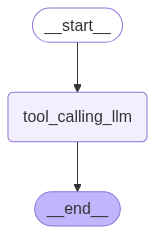

In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [19]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Here is the result of multiplying 2 and 3:'}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_xUFBjEOuRxCUWwawDYHAkA'}]
Tool Calls:
  multiply (tooluse_xUFBjEOuRxCUWwawDYHAkA)
 Call ID: tooluse_xUFBjEOuRxCUWwawDYHAkA
  Args:
    a: 2
    b: 3
